### Goal: 
to predict motion based on time series data for various motion types

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motionsense-dataset/data_subjects_info.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_19.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_20.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_10.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_15.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_18.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_1.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_2.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_9.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_4.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_2/sub_5.csv
/kaggle/input/motionsense-dataset/A_De

Load the subject csv file

In [3]:
pd_subjects = pd.read_csv('/kaggle/input/motionsense-dataset/data_subjects_info.csv')
pd_subjects.head()

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0


In [4]:
pd_subjects.shape

(24, 5)

As the instruction file mentioned, there are 6 motion types:

1. dws: downstairs
2. ups: upstairs
3. sit: sitting
4. std: standing
5. wlk: walking
6. jog: jogging

In [5]:
motion_types = ["dws", "ups", "sit", "std", "wlk", "jog"]

import glob

# Loop through motion types
for motion in motion_types:
    
    # Just list one for testing
    if (motion=='dws'):
        file_long = "/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/" + motion + "_[0-9]/*.csv"
        file_short = "/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/" + motion + "_1[0-9]/*.csv"

        files_long = glob.glob(file_long)
        files_short = glob.glob(file_short)

Looking at one of the subjects as a test:

In [6]:
pd_test = pd.read_csv(files_short[0], index_col = 0)
pd_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-2.513094,-1.412011,0.925811,-0.092959,0.987420,0.127899,0.340219,-1.286485,0.268217,-0.576917,-0.160363,0.015244
1,-2.535334,-1.420246,0.932903,-0.085455,0.988689,0.123248,0.371612,-1.561942,0.128852,-0.385522,-0.041927,0.123823
2,-2.549464,-1.427441,0.952189,-0.079732,0.989742,0.118535,0.388283,-1.700286,0.078939,-0.244685,-0.055752,0.244151
3,-2.555566,-1.434708,0.981065,-0.075028,0.990754,0.113025,0.427973,-1.712964,0.018344,-0.161926,-0.086625,0.274975
4,-2.539599,-1.443964,1.027616,-0.071627,0.991968,0.104250,0.730818,-1.320737,-0.029182,0.092516,-0.112176,-0.277346


Plot to see what it looks like

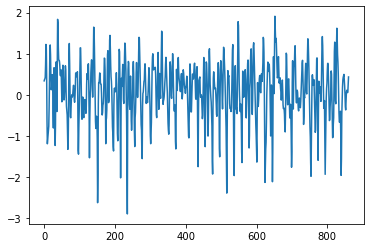

In [7]:
plt.plot(pd_test['rotationRate.x'])

An idea:
- analyze the time series data with ARIMA techniques
- feed the components into neural network to identify the motion

In [8]:
from statsmodels.api import tsa

pd_test.index = pd.to_datetime(pd_test.index)
pd_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
1970-01-01 00:00:00.000000000,-2.513094,-1.412011,0.925811,-0.092959,0.987420,0.127899,0.340219,-1.286485,0.268217,-0.576917,-0.160363,0.015244
1970-01-01 00:00:00.000000001,-2.535334,-1.420246,0.932903,-0.085455,0.988689,0.123248,0.371612,-1.561942,0.128852,-0.385522,-0.041927,0.123823
1970-01-01 00:00:00.000000002,-2.549464,-1.427441,0.952189,-0.079732,0.989742,0.118535,0.388283,-1.700286,0.078939,-0.244685,-0.055752,0.244151
1970-01-01 00:00:00.000000003,-2.555566,-1.434708,0.981065,-0.075028,0.990754,0.113025,0.427973,-1.712964,0.018344,-0.161926,-0.086625,0.274975
1970-01-01 00:00:00.000000004,-2.539599,-1.443964,1.027616,-0.071627,0.991968,0.104250,0.730818,-1.320737,-0.029182,0.092516,-0.112176,-0.277346


In [9]:
# Decompose the time series
ts_rotationRate_x = pd_test['rotationRate.x']
dc_rotationRate_x = tsa.seasonal_decompose(ts_rotationRate_x, model='additive')

1970-01-01 00:00:00.000000000    0.340219
1970-01-01 00:00:00.000000001    0.371612
1970-01-01 00:00:00.000000002    0.388283
1970-01-01 00:00:00.000000003    0.427973
1970-01-01 00:00:00.000000004    0.730818
Name: rotationRate.x, dtype: float64